In [1]:
import cv2
import sys 
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import random
from skimage.feature import local_binary_pattern


In [40]:
def item_freq(a):
    items, freq = np.unique(a, return_counts=True)
    return np.array([items, freq]).T

class ImageItem:
    def __init__(self, image_name, image_path, image_class):
        self.image_name = image_name
        self.image_path = image_path
        self.image_class = image_class  
        
    def read_image(self):
        return cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
    
    def __str__(self):
        return "class: '%s', path: '%s'" % (self.image_class, self.image_path)

class ImageItemCollection:
    def __init__(self):
        self.array = []
        self.by_class = {}
        
    def append(self, image_item):
        self.array.append(image_item)
        if not (image_item.image_class in self.by_class):
            self.by_class[image_item.image_class] = []
        self.by_class[image_item.image_class].append(image_item)
        
    def build_training_and_validation_sets(self, training_pct = 0.7):
        training_set = []
        validation_set = []
        for class_key in self.by_class:
            class_items = items.by_class[class_key]
            training_ammount = int(len(class_items) * training_pct)

            #shuffle without changing image_collection following functional principles
            shuffle_result = sorted(class_items, key=lambda class_items: random.random())

            for i in range(0,len(shuffle_result)):
                if i < training_ammount:
                    training_set.append(shuffle_result[i])
                else:
                    validation_set.append(shuffle_result[i])
        return (training_set, validation_set)
    
class EpDefaultReader:
    @staticmethod
    def list_files(folder_path):
        folder_items = os.listdir(folder_path)
        folder_files = [f for f in folder_items if isfile(join(folder_path, f))]
        return folder_files
    @staticmethod
    def get_image_class(folder_file):
        return folder_file.split("_")[0]
    @staticmethod
    def load_items(folder_path):
        folder_files = EpDefaultReader.list_files(folder_path)
        if len(folder_files) <= 0:
            raise ValueError("Folder should contain at least one file")
        items = ImageItemCollection()
        for folder_file in folder_files:
            full_path = join(folder_path, folder_file)
            image_class = EpDefaultReader.get_image_class(folder_file)
            items.append(ImageItem(folder_file, full_path, image_class))
        return items

class LbpResult:
    def __init__(self, image, image_class, lbp):
        self.image = image
        self.image_class = image_class
        self.lbp = lbp
        orig_histogram = item_freq(lbp.ravel())
        self.histogram = orig_histogram[:, 1]/sum(orig_histogram[:, 1])
        
    def plot(self):
        x = np.arange(0, len(self.histogram))

        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(self.image, cmap='gray')
        ax[0].set_title("Classe: %s" % (self.image_class))
        ax[1].imshow(self.lbp, cmap='gray')
        ax[1].set_title("LBP")
        ax[2].bar(x, self.histogram)
        ax[2].set_ylim([0, 1])
        ax[2].set_title("Histograma Normalizado")
        
        plt.show()

def calculate_lbp(image, image_class, radius = 2):
    no_points = 8 * radius
    # Uniform LBP is used
    lbp = local_binary_pattern(image, no_points, radius, method='uniform')
    return LbpResult(image, image_class, lbp)

def calculate_images_lbp(image_set, radius = 2):
    lbp_results = []
    for item in image_set:
        image = item.read_image()
        lbp_result = calculate_lbp(image, item.image_class, radius = 2)
        lbp_results.append(lbp_result)
    return lbp_results


# OpenCV uses sum of squared distance as compactnes s
def sum_of_squared_distances(point_a, point_b):
    return np.sum((point_a - point_b)**2)

def print_confusion_matrix(original_labels, result_labels, confusion_matrix):
    acc = ""
    acc += "---"*len(confusion_matrix[0])*3+"\n"
    acc += " \t|"
    for item in original_labels:
        acc += item + "\t"
    acc += "\n"
    for i in range(len(confusion_matrix)):
        lin = confusion_matrix[i]
        acc += "---"*len(lin)*3+"\n"
        acc += str(result_labels[i])+"\t|"
        for inlin in lin:
            acc += str(int(inlin))+"\t"
        acc += "\n"
    acc += "---"*len(lin)*3+"\n"
    print(acc)

    
def classify(current_hist, centers):
    min_i = -1
    min_error = sys.float_info.max
    
    for i in range(len(centers)):
        center = centers[i]
        current_error = sum_of_squared_distances(current_hist, center)
        if min_error > current_error:
            min_i = i
            min_error = current_error
    return min_i

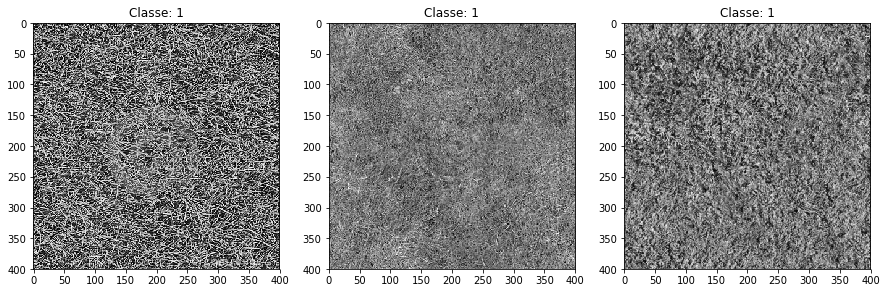

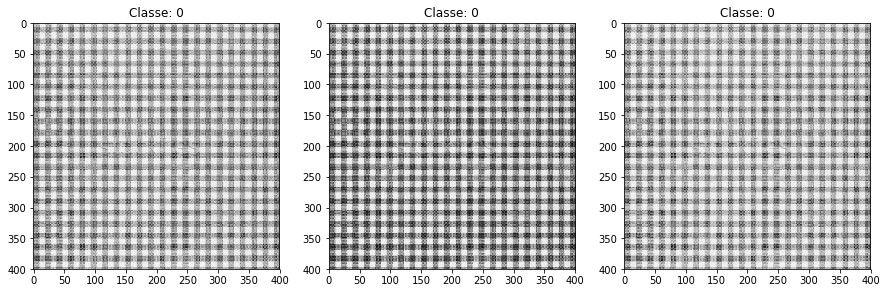

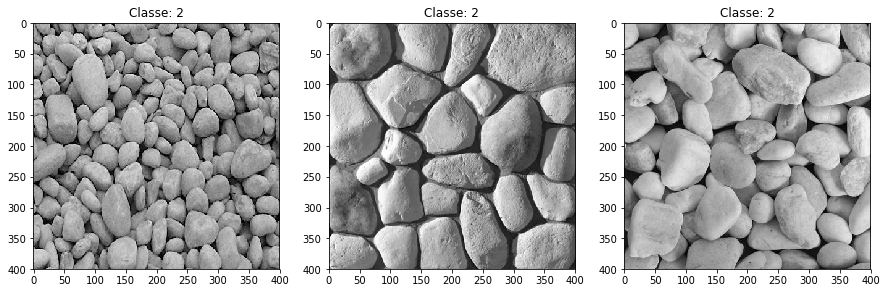

In [3]:
folder_path = '../atividade_final/dat'

items = EpDefaultReader.load_items(folder_path)

for class_key in items.by_class:
    class_items = items.by_class[class_key]
    fig, imgs = plt.subplots(1,len(class_items), figsize=(15,5))
    for i in range(len(class_items)):
        image = class_items[i].read_image()
        imgs[i].imshow(image, cmap='gray')
        imgs[i].set_title("Classe: %s" % (class_items[i].image_class))
    plt.show()
    

Training


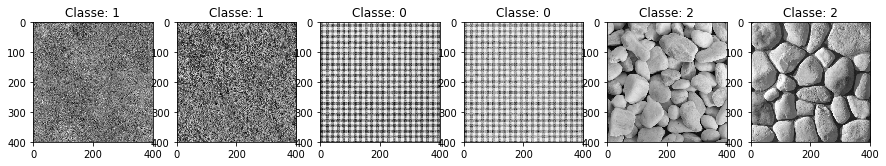

Validation


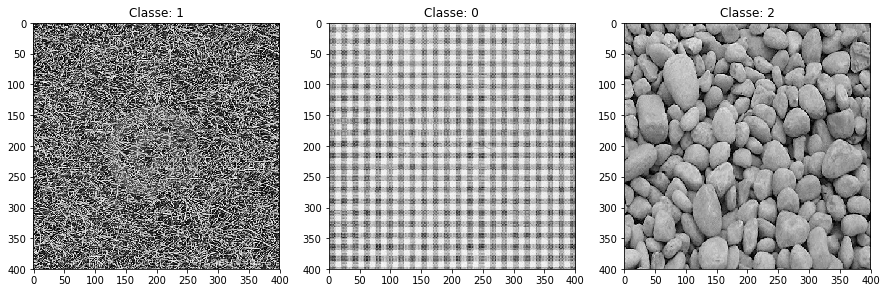

In [4]:
(training_set, validation_set) = items.build_training_and_validation_sets()

print("Training")
fig, imgs = plt.subplots(1,len(training_set), figsize=(15,5))
for i in range(len(training_set)):
    item = training_set[i]
    image = item.read_image()
    imgs[i].imshow(image, cmap='gray')
    imgs[i].set_title("Classe: %s" % (item.image_class))
plt.show()
    
print("Validation")
fig, imgs = plt.subplots(1,len(validation_set), figsize=(15,5))
for i in range(len(validation_set)):
    item = validation_set[i]
    image = item.read_image()
    imgs[i].imshow(image, cmap='gray')
    imgs[i].set_title("Classe: %s" % (item.image_class))
plt.show()


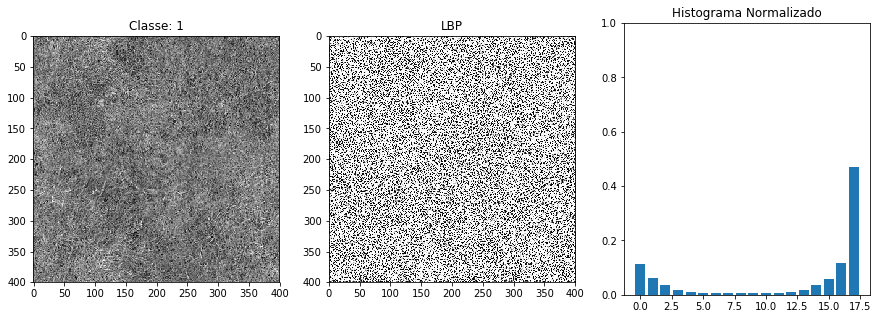

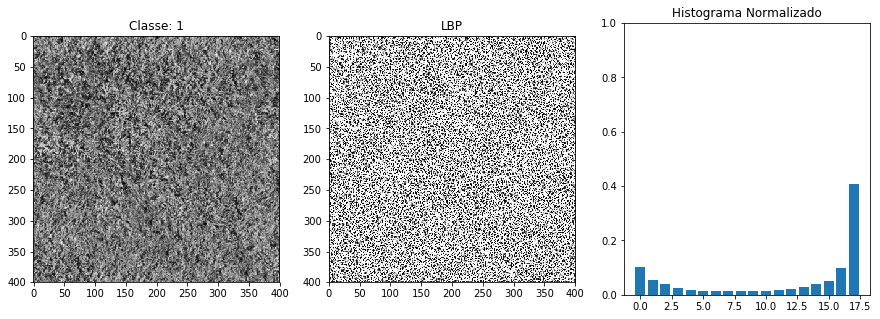

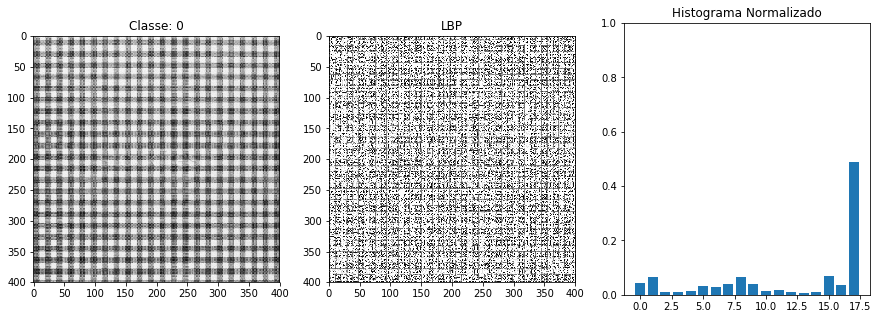

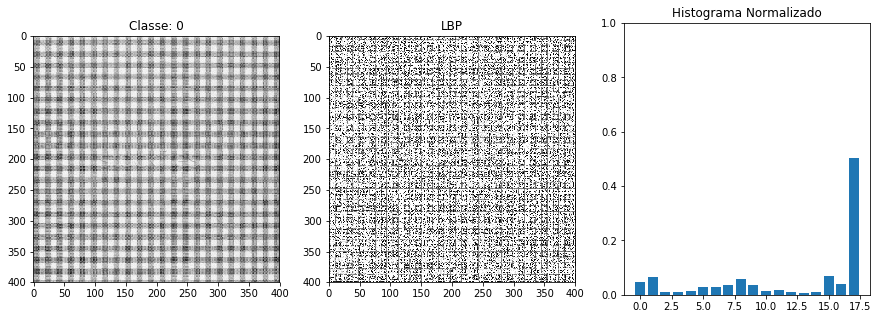

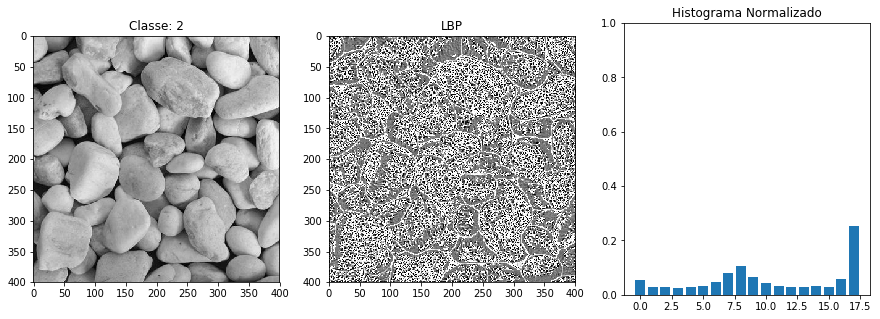

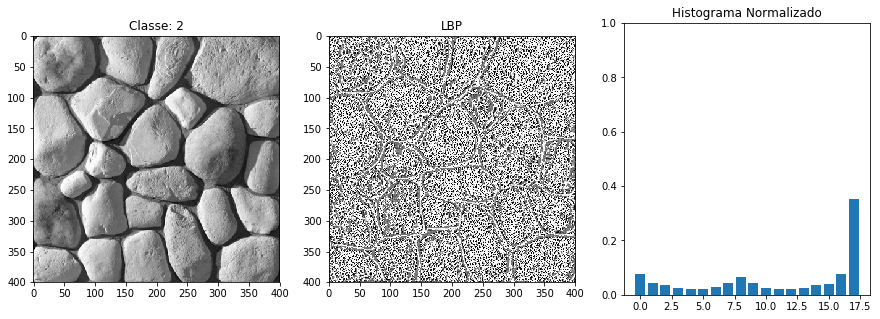

In [5]:
lbp_results = calculate_images_lbp(training_set)
for lbp_result in lbp_results:
    lbp_result.plot()

Labels: [[2 2 0 0 1 1]]
Compacteness: 0.010238498362
Centers Length: 3
Centers: [[0.04614688 0.06564375 0.0094     0.0091125  0.01318438 0.02995938
  0.02939063 0.03670938 0.06245    0.03712812 0.01405312 0.0168375
  0.00930312 0.00742813 0.01024687 0.06775    0.0393     0.49595624]
 [0.06419375 0.0361375  0.03186875 0.02528125 0.02429063 0.0271375
  0.03635938 0.06200313 0.08537813 0.05493125 0.0340875  0.02686875
  0.02393438 0.02790312 0.03403438 0.0347875  0.06730312 0.3035    ]
 [0.107775   0.05905625 0.0385875  0.02184375 0.01464687 0.01182813
  0.01025625 0.00980937 0.01005    0.01132187 0.01075    0.01298437
  0.01655938 0.02429063 0.03933125 0.05401563 0.10818125 0.43871248]]



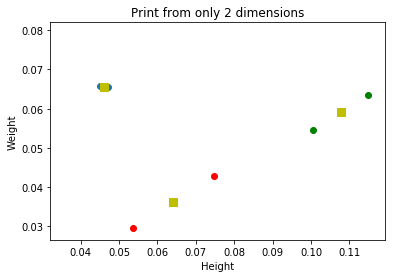

In [6]:
x = []
for lbp in lbp_results:
    x.append(np.float32(lbp.histogram))

k_means_input=np.array(x)
    
k_size = 3
max_iteration = 10
accuracy = 0.3
    
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
            max_iteration, 
            accuracy)

compactness, labels, centers = cv2.kmeans(k_means_input,
                                          k_size,
                                          None,
                                          criteria,
                                          10,
                                          cv2.KMEANS_RANDOM_CENTERS)

print "Labels: %s"% str(labels.T)
print "Compacteness: %s"% str(compactness)
print "Centers Length: %s"% str(len(centers)) 
print "Centers: %s"% str(centers) 

# Now separate the data, Note the flatten()
A = k_means_input[labels.ravel()==0]
B = k_means_input[labels.ravel()==1]
C = k_means_input[labels.ravel()==2]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(C[:,0],C[:,1],c = 'g')
plt.scatter(centers[:,0],centers[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.title("Print from only 2 dimensions")
plt.show()



In [7]:
validation_lbp_results = calculate_images_lbp(validation_set)

keys_array = items.by_class.keys()

confusion_matrix = np.zeros((len(keys_array),len(keys_array)))
for validation_lbp in validation_lbp_results:
    current_hist = np.float32(validation_lbp.histogram)
    
    classified_center = classify(current_hist, centers)
    
    index_of_key = keys_array.index(validation_lbp.image_class)
    confusion_matrix[index_of_key, classified_center] += 1
    
result_labels = np.arange(0,k_size)
print "\nValidation Confusion Matrix"
print_confusion_matrix(keys_array, result_labels, confusion_matrix)
    



Validation Confusion Matrix
---------------------------
 	|1	0	2	
---------------------------
0	|0.0	0.0	1.0	
---------------------------
1	|1.0	0.0	0.0	
---------------------------
2	|0.0	1.0	0.0	
---------------------------



In [8]:
lbp_results = calculate_images_lbp(items.array)

keys_array = items.by_class.keys()

confusion_matrix = np.zeros((len(keys_array),len(keys_array)))
for lbp_result in lbp_results:
    current_hist = np.float32(lbp_result.histogram)
    
    classified_center = classify(current_hist, centers)
    
    index_of_key = keys_array.index(lbp_result.image_class)
    confusion_matrix[index_of_key, classified_center] += 1
    

result_labels = np.arange(0,k_size)
print "\nAll Confusion Matrix"
print_confusion_matrix(keys_array, result_labels, confusion_matrix)


All Confusion Matrix
---------------------------
 	|1	0	2	
---------------------------
0	|0.0	0.0	3.0	
---------------------------
1	|3.0	0.0	0.0	
---------------------------
2	|0.0	3.0	0.0	
---------------------------



# Using Vistex Textures

In [46]:
folder_path = '../dataset/VisTex/selected'


class VistexReader:
    @staticmethod
    def list_files(folder_path):
        folder_items = os.listdir(folder_path)
        folder_files = [f for f in folder_items if isfile(join(folder_path, f))]
        return folder_files
    @staticmethod
    def get_image_class(folder_file):
        split_result = folder_file.split(".")
        if split_result[len(split_result) -1] != "ppm":
            print "ERROR: "+folder_file
        return split_result[0]
    @staticmethod
    def load_items(folder_path):
        folder_files = EpDefaultReader.list_files(folder_path)
        if len(folder_files) <= 0:
            raise ValueError("Folder should contain at least one file. Copy and paste images from original downloaded file to a specific one which contains all images. Used folders: FLAT/128x128, FLAT/128x192, FLAT/192x128")
        items = ImageItemCollection()
        for folder_file in folder_files:
            full_path = join(folder_path, folder_file)
            image_class = VistexReader.get_image_class(folder_file)
            items.append(ImageItem(folder_file, full_path, image_class))
        return items


items = VistexReader.load_items(folder_path)

print("Class count: %i"% len(items.by_class.keys()))


for item_class in items.by_class.keys():
    items_array = items.by_class[item_class]
    
    print("Item Class: '%s' \t Count: %i"%(item_class, len(items_array)))

    
    
(training_set, validation_set) = items.build_training_and_validation_sets()

print("Training Set count: '%i' \t Validation Set count: '%i'"%(len(training_set), len(validation_set)))
 

Class count: 19
Item Class: 'WheresWaldo' 	 Count: 3
Item Class: 'Buildings' 	 Count: 11
Item Class: 'Flowers' 	 Count: 8
Item Class: 'Clouds' 	 Count: 2
Item Class: 'Fabric' 	 Count: 20
Item Class: 'Paintings' 	 Count: 13
Item Class: 'Food' 	 Count: 12
Item Class: 'Terrain' 	 Count: 11
Item Class: 'Leaves' 	 Count: 17
Item Class: 'Metal' 	 Count: 6
Item Class: 'Stone' 	 Count: 6
Item Class: 'Water' 	 Count: 8
Item Class: 'Sand' 	 Count: 7
Item Class: 'Wood' 	 Count: 3
Item Class: 'Tile' 	 Count: 11
Item Class: 'Misc' 	 Count: 4
Item Class: 'Bark' 	 Count: 13
Item Class: 'Grass' 	 Count: 3
Item Class: 'Brick' 	 Count: 9
Training Set count: '109' 	 Validation Set count: '58'


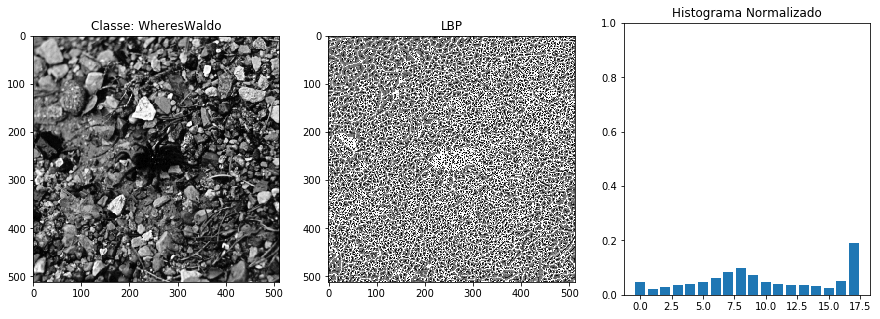

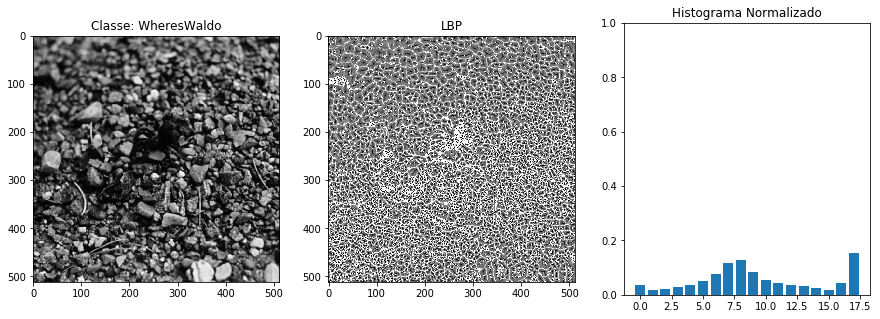

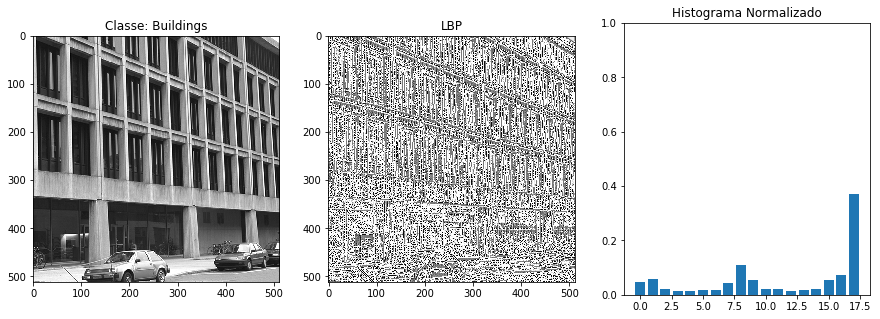

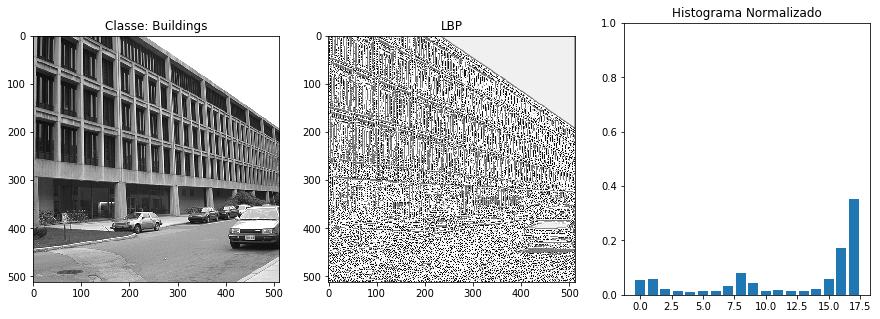

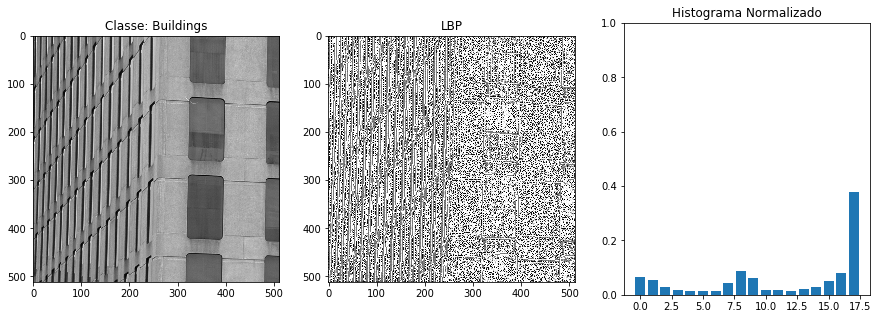

In [53]:
lbp_results = calculate_images_lbp(training_set,3)
plot_examples = lbp_results[0:5]
for lbp_result in plot_examples:
    lbp_result.plot()

In [ ]:
x = []
for lbp in lbp_results:
    x.append(np.float32(lbp.histogram))

k_means_input=np.array(x)
    
k_size = len(items.by_class.keys())
max_iteration = 5000
accuracy = 0.001
    
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
            max_iteration, 
            accuracy)

compactness, labels, centers = cv2.kmeans(k_means_input,
                                          k_size,
                                          None,
                                          criteria,
                                          10,
                                          cv2.KMEANS_RANDOM_CENTERS)

print "Labels: %s"% str(labels.T)
print "Compacteness: %s"% str(compactness)
print "Centers Length: %s"% str(len(centers)) 
print "Centers: %s"% str(centers) 


lbp_results = calculate_images_lbp(training_set)
keys_array = items.by_class.keys()

confusion_matrix = np.zeros((len(keys_array),len(keys_array)))
for lbp_result in lbp_results:
    current_hist = np.float32(lbp_result.histogram)
    
    classified_center = classify(current_hist, centers)
    
    index_of_key = keys_array.index(lbp_result.image_class)
    confusion_matrix[index_of_key, classified_center] += 1
    

result_labels = np.arange(0,k_size)
print "\nFrom Training Set Confusion Matrix"
print_confusion_matrix(keys_array, result_labels, confusion_matrix)

Labels: [[ 1 15  4 12  5 12  5  6  5 10  1  9 15 10 16  6 16 11 16 17 16  6 18 18
  16 14 16 18 16  6  1  1 17 16 15 17 17  1  7  2 10 13 10 13 11 11  1 17
   9  9 17  9 17 11 17  4 17 18  8 11 15 17  7 10 16 18  6 18  1  1 14 17
  10  5  5 11  5 14 17 17  0 15 16  4 16  3 16 18 10  4 17 10 14  6 15 15
   6  1  6 10 17  6  6  5 17 10 17 17 18]]
Compacteness: 0.0836944495459
Centers Length: 19
Centers: [[0.02924347 0.01100922 0.01571655 0.024189   0.03702545 0.05685043
  0.08826447 0.12569809 0.1266365  0.10195541 0.07265091 0.05475616
  0.03923035 0.02868652 0.02101898 0.01405716 0.03269958 0.12031174]
 [0.04621294 0.02413601 0.02995173 0.03482522 0.03826523 0.04440562
  0.05466631 0.07445145 0.09054735 0.07482401 0.05341255 0.04381985
  0.03823853 0.03615146 0.03236983 0.02438778 0.05463028 0.20470387]
 [0.01023102 0.00713348 0.00996399 0.01500702 0.01700974 0.03408813
  0.06290436 0.14860916 0.21061325 0.13958359 0.07094955 0.05257416
  0.02738953 0.02509308 0.01834869 0.00954819 0.0